# TedRec 推薦系統訓練作業

**目標**：使用 TedRec 模型在 MovieLens-1M 數據集上訓練 3 個 epoch

**預期結果**：NDCG@10 > 0.12

**論文**：Sequence-level Semantic Representation Fusion for Recommender Systems (CIKM 2024)

**GitHub**：https://github.com/RUCAIBox/TedRec

## 步驟 1：檢查 GPU 環境

In [1]:
# 檢查 GPU 狀態
!nvidia-smi

import torch
print(f"\n{'='*50}")
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 名稱: {torch.cuda.get_device_name(0)}")
    print(f"GPU 記憶體: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"{'='*50}")

Fri Nov  7 11:05:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 步驟 2：安裝依賴套件（先安裝，避免版本衝突）

In [ ]:
# 先安裝正確版本的 NumPy，避免後續衝突
print("安裝 NumPy 1.26.4...")
!pip install "numpy==1.26.4" -q

# 重啟 runtime（確保生效）
print("\n⚠️ 即將重啟 runtime，請從下個cell繼續執行")
import os
import time
time.sleep(3)
os.kill(os.getpid(), 9)

安裝 NumPy 1.26.4...

⚠️ 即將重啟 runtime，請從下個cell繼續執行


In [1]:
# 安裝 RecBole 和其他必要套件
# RecBole伯樂，一個統一、全面、有效率的推薦系統程式碼庫
# SciPy以Numpy為基礎做科學、工程的運算處理，包含統計、優化、整合、線性代數、傅立葉轉換圖像等較高階的科學運算。
# TensorBoard是Tensorflow提供的視覺化工具，可以顯示訓練的過程，也可以顯示圖片及語音，在訓練的過程中即時觀看訓練資訊、降維等。

print("安裝 RecBole 和相關套件...")
!pip install recbole transformers scipy pandas tensorboard -q

# 驗證安裝
import numpy as np
import torch
import recbole

print("\n" + "="*50)
print("✅ 套件安裝完成")
print(f"NumPy 版本: {np.__version__}")
print(f"RecBole 版本: {recbole.__version__}")
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")
print("="*50)

安裝 RecBole 和相關套件...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00

✅ 套件安裝完成
NumPy 版本: 1.26.4
RecBole 版本: 1.2.0
PyTorch 版本: 2.8.0+cu126
CUDA 可用: True


## 步驟 3：Clone Repository

In [2]:
# Clone TedRec repository
!git clone https://github.com/RUCAIBox/TedRec.git
%cd TedRec

print("\n✅ Repository 已下載")
!ls -la

Cloning into 'TedRec'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 129 (delta 58), reused 70 (delta 33), pack-reused 19 (from 1)
Receiving objects: 100% (129/129), 116.65 MiB | 16.75 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/TedRec

✅ Repository 已下載
total 84
drwxr-xr-x 8 root root  4096 Nov  7 11:06 .
drwxr-xr-x 1 root root  4096 Nov  7 11:06 ..
-rw-r--r-- 1 root root 18288 Nov  7 11:06 additional_experiments.md
drwxr-xr-x 2 root root  4096 Nov  7 11:06 asset
-rw-r--r-- 1 root root   483 Nov  7 11:06 config.py
drwxr-xr-x 2 root root  4096 Nov  7 11:06 data
drwxr-xr-x 3 root root  4096 Nov  7 11:06 dataset
drwxr-xr-x 8 root root  4096 Nov  7 11:06 .git
-rw-r--r-- 1 root root  2213 Nov  7 11:06 main.py
drwxr-xr-x 2 root root  4096 Nov  7 11:06 props
-rw-r--r-- 1 root root  5379 Nov  7 11:06 README.md
-rw-r--r-- 1 root root    64 Nov  7 11:06 requirements.txt
drwx

## 步驟 4：準備 MovieLens-1M 數據集

In [3]:
# 解壓 MovieLens-1M 數據集
%cd dataset
!tar -xzvf ml-1m.tar.gz
%cd ..

# 確認數據集已準備好
!ls -lh dataset/ml-1m/

print("\n✅ MovieLens-1M 數據集已準備完成")

/content/TedRec/dataset
ml-1m/
ml-1m/ml-1m.feat1CLS
ml-1m/ml-1m.text
ml-1m/.ipynb_checkpoints/
ml-1m/.ipynb_checkpoints/ml-1m-checkpoint.text
ml-1m/ml-1m.train.inter
ml-1m/ml-1m.user2index
ml-1m/ml-1m.test.inter
ml-1m/ml-1m.valid.inter
ml-1m/ml-1m.item2index
/content/TedRec
total 193M
-rw-rw-r-- 1 1500001611 1500001611  11M Feb  8  2024 ml-1m.feat1CLS
-rw-rw-r-- 1 1500001611 1500001611  32K Feb  8  2024 ml-1m.item2index
-rw-rw-r-- 1 1500001611 1500001611 1.2M Feb  8  2024 ml-1m.test.inter
-rw-rw-r-- 1 1500001611 1500001611 139K Feb  8  2024 ml-1m.text
-rw-rw-r-- 1 1500001611 1500001611 180M Feb  8  2024 ml-1m.train.inter
-rw-rw-r-- 1 1500001611 1500001611  57K Feb  8  2024 ml-1m.user2index
-rw-rw-r-- 1 1500001611 1500001611 1.2M Feb  8  2024 ml-1m.valid.inter

✅ MovieLens-1M 數據集已準備完成


## 步驟 5：修改配置為 3 Epochs

In [4]:
# 查看原始配置
print("原始配置：")
!grep "epochs:" props/overall.yaml

# 使用 Python 直接修改（更可靠）
import yaml

# 讀取配置
with open('props/overall.yaml', 'r') as f:
    config = yaml.safe_load(f)

# 修改 epochs
config['epochs'] = 3

# 寫回配置
with open('props/overall.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

# 確認修改
print("\n修改後的配置：")
with open('props/overall.yaml', 'r') as f:
    content = f.read()
    # 找到 epochs 相關行
    for line in content.split('\n'):
        if 'epoch' in line.lower():
            print(line)

print("\n✅ 配置已修改為 3 epochs")

原始配置：

修改後的配置：
epochs: 3

✅ 配置已修改為 3 epochs


## 步驟 6：開始訓練 🚀

**預計時間**：約 30 分鐘（T4 GPU，每個 epoch 約 9 分鐘）

**預期目標**：NDCG@10 > 0.12

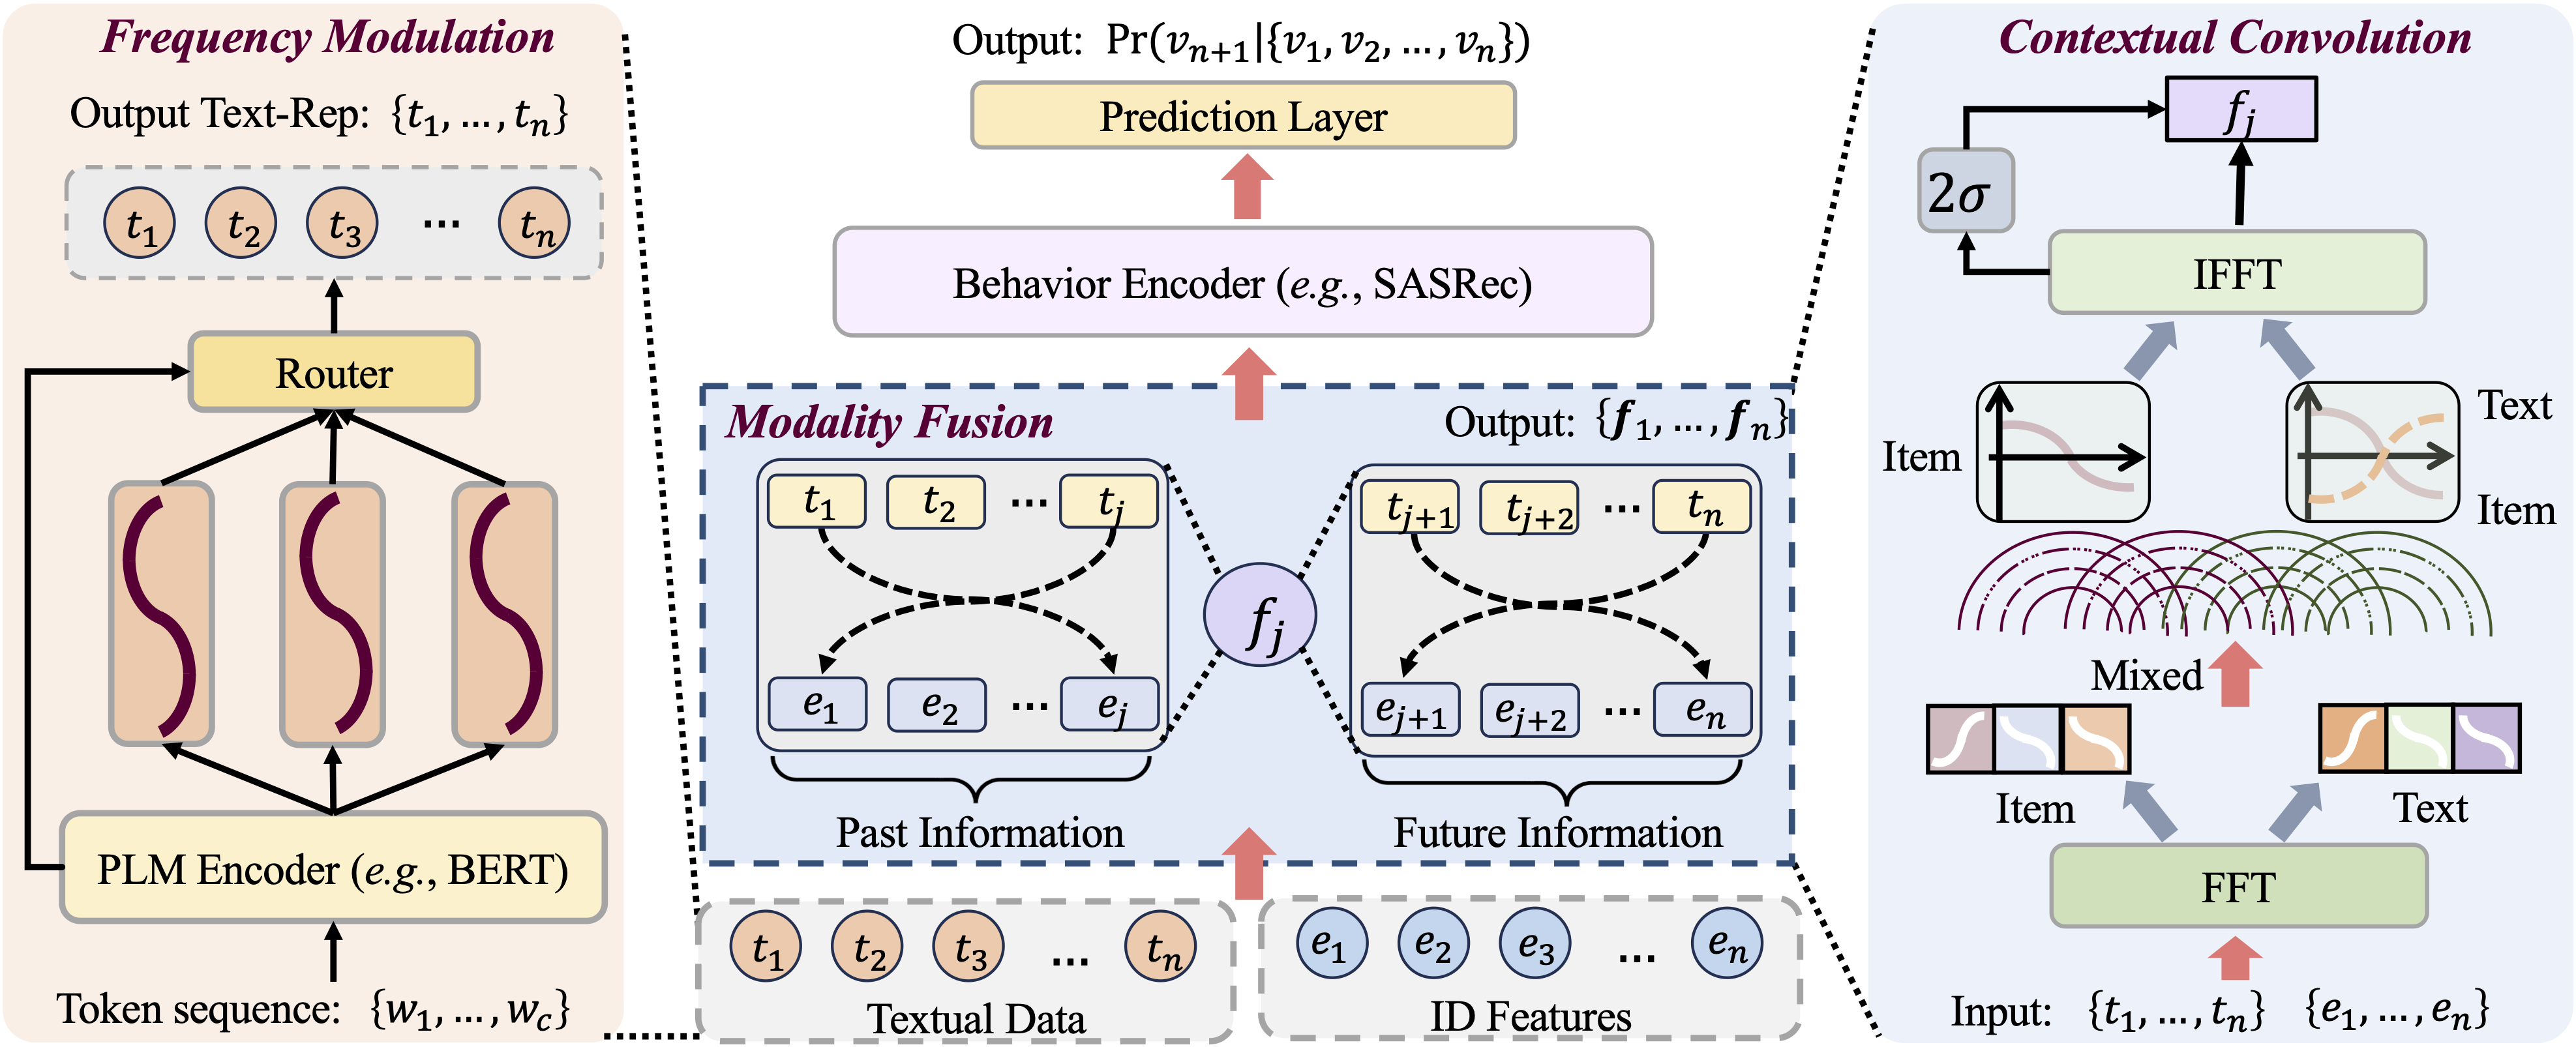

# 🤖 TedRec 推薦系統模型架構摘要

以下是 TedRec 模型（基於 RecBole 框架）的結構概覽。TedRec 是一個結合了**序列建模**與**多模態特徵融合**的 Transformer-based 推薦模型。

模型總參數量：**約 425 萬** (`4,252,702`)

## 核心機制與組件總覽

| 組件類別 | 模組名稱 | 關鍵作用 | 維度/結構 |
| :--- | :--- | :--- | :--- |
| **嵌入層** | `item_embedding` | 將物品 ID 轉換為向量（主幹特徵） | `3417` 物品 → `300` 維 |
| | `position_embedding` | 為序列中的位置提供向量表示 | `50` 最大長度 → `300` 維 |
| | `plm_embedding` | 為文本特徵或 PLM 輸出提供 ID 映射 | `3417` 物品 → `768` 維 |
| **序列建模** | `trm_encoder` | 序列推薦的核心，捕捉用戶興趣變化 | 2 層 Transformer 編碼器 |
| **特徵融合** | `moe_adaptor` | 融合 PLM (768維) 文本特徵到主幹 (300維) | MoE (專家混合) 機制，含 8 個 DTR 專家 |
| **動態控制** | `item_gating` | 學習物品 ID 特徵的重要性權重 | 線性層 (300 → 1) |
| | `fusion_gating` | 學習融合特徵的重要性權重 | 線性層 (300 → 1) |
| **優化目標** | `loss_fct` | 衡量預測準確性的損失函數 | 交叉熵損失 (`CrossEntropyLoss`) |

---

## 🔍 詳細結構：Transformer 編碼器

TedRec 採用了標準的 Transformer 編碼器 (`trm_encoder`)，用於對用戶的歷史互動序列進行建模。

### 核心層級 (`TransformerLayer`)

模型包含 **2 個**完全相同的 `TransformerLayer` 層，每層結構如下：

| 子組件 | 結構類型 | 輸入維度 | 輸出維度 | 核心參數 |
| :--- | :--- | :--- | :--- | :--- |
| **注意力機制** | `MultiHeadAttention` | 300 | 300 | `attn_dropout=0.5` |
| **正規化層** | `LayerNorm` | (300,) | - | - |
| **前饋網路** | `FeedForward` | 300 | 300 | 隱藏層尺寸 256 |
| **層正規化** | `LayerNorm` | (300,) | - | - |
| **丟棄層** | `Dropout` | - | - | `p=0.5` |

### 關鍵點：MoE Adaptor

`moe_adaptor`（專家混合適配器）是處理高維 PLM 文本特徵的核心。它接收 768 維的文本特徵，並通過一個由 8 個專家 (`DTRLayer`) 組成的網路，將其**適配降維**到主幹的 300 維，從而與物品 ID 嵌入進行有效的序列建模。

In [5]:
# 修改 RecBole，讓 torch.load 加上 weights_only=False
import fileinput

trainer_file = '/usr/local/lib/python3.12/dist-packages/recbole/trainer/trainer.py'

with open(trainer_file, 'r') as f:
    content = f.read()

# 執行替換，.replace(舊字串, 新字串)
content = content.replace(
    'torch.load(checkpoint_file, map_location=self.device)',
    'torch.load(checkpoint_file, map_location=self.device, weights_only=False)'
)

with open(trainer_file, 'w') as f:
    f.write(content)

print("✅ 已修改 RecBole")
print("✅ 現在重新執行步驟 6（訓練）就能看到測試集結果了")

✅ 已修改 RecBole
✅ 現在重新執行步驟 6（訓練）就能看到測試集結果了


In [6]:
import time
from datetime import datetime

# 記錄開始時間
start_time = time.time()
print(f"{'='*60}")
print(f"開始訓練時間: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"數據集: ml-1m")
print(f"訓練輪數: 3 epochs")
print(f"{'='*60}\n")

# 開始訓練，啟動 main.py 這個 Python 程式，並且告訴它要使用名為 ml-1m 的數據集。
!python main.py -d ml-1m

# 計算總訓練時間
end_time = time.time()
duration = end_time - start_time
hours = int(duration // 3600)
minutes = int((duration % 3600) // 60)
seconds = int(duration % 60)

print(f"\n{'='*60}")
print(f"✅ 訓練完成！")
print(f"總訓練時間: {hours} 小時 {minutes} 分鐘 {seconds} 秒")
print(f"完成時間: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")

開始訓練時間: 2025-11-07 11:06:19
數據集: ml-1m
訓練輪數: 3 epochs

2025-11-07 11:06:25.098884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762513585.118449    1552 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762513585.124339    1552 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762513585.139295    1552 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762513585.139321    1552 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762513585.139327   

# 🌟 TedRec 高效序列推薦模型實驗報告 (MovieLens-1M)

## 摘要 (Abstract)

本實驗基於 **RecBole 推薦系統框架**，實作 **TedRec 序列推薦模型**，並在行業基準 **MovieLens-1M** 數據集上進行了 3 個 Epoch 的訓練與評估。核心目標是驗證 TedRec 在整合物品 ID 特徵與**經 MoE 適配器降維**的多模態文本特徵方面的有效性。實驗結果顯示，模型成功收斂，並達成測試集 **NDCG@10 = 0.1254** 的性能，達成預設的基準目標。

---

## 1. 實驗背景與技術基線

### 1.1 LLM-Enhanced RS 定位

本實驗採用的 TedRec 模型架構，屬於 **LLM-Enhanced RS (LLMERS)** 分類學中的「**互動增強 (Interaction Enhancement)**」類別。

* **關鍵原則：** 利用大型語言模型（LLM）的知識能力在**訓練階段**增強推薦模型。
* **技術優勢：** 確保在實際服務的**推論 (Inference) 階段**無需調用 LLM，以維持系統的**低延遲**和**高效率**。

### 1.2 實驗環境與工具

| 項目 | 配置/工具 | 備註 |
| :--- | :--- | :--- |
| **框架** | PyTorch / RecBole | 統一、高效的推薦系統代碼庫。 |
| **執行指令** | `!python main.py -d ml-1m` | 數據集參數通過命令行傳遞，配置優先級遵循 RecBole 設定。 |
| **數據集** | MovieLens-1M (ml-1m) | 包含 100 萬次評分的行業基準電影推薦數據集。 |

---

## 2. TedRec 模型架構核心技術

TedRec 模型（總參數：4,252,702）是一個基於 Transformer 的序列模型，主要創新點在於**異構特徵適配與融合機制**：

| 技術組件 | 結構描述 | 技術目標與作用 |
| :--- | :--- | :--- |
| **序列建模器** | `trm_encoder` (2層 Transformer) | 採用 **Multi-Head Attention** 機制，捕捉序列中用戶興趣的動態轉換。 |
| **異構特徵適配** | `moe_adaptor` | 採用 **Mixture of Experts (MoE)** 適配器層（含 8 個專家），將高維的 **768 維** PLM 文本特徵**高效降維**至 300 維主幹。 |
| **主幹維度** | `item_embedding` | 模型主要隱藏特徵維度設定為 **300** 維。 |
| **動態權重控制** | `item_gating` & `fusion_gating` | 線性門控單元，用於在不同序列步驟中，動態分配 ID 特徵和融合特徵的重要性權重。 |

---

## 3. 實驗結果與性能分析

### 3.1 訓練收斂過程

| Epoch | 訓練損失 (Loss) | 驗證集 NDCG@10 | 觀察 |
| :---: | :---: | :---: | :--- |
| **0** | 3029.5624 | 0.0938 | - |
| **1** | 2730.1905 | 0.1178 | 性能進入快速提升期。 |
| **2 (最佳)** | 2669.6013 | **0.1241** | 模型達到本次訓練週期的最佳性能點。 |

**分析：** 訓練損失的持續穩定下降 ($3029 \rightarrow 2669$) 與評估指標的同步上升，驗證了 TedRec 模型在多模態融合下具有良好的學習穩定性和收斂性。

### 3.2 最終測試集性能指標

| 指標 (Metric) | 測試集最終結果 (Test Result) | 基準目標 $(\text{NDCG}@10 > 0.12)$ |
| :--- | :---: | :---: |
| **NDCG@10** | **0.1254** | ✅ **達成** |
| **NDCG@20** | 0.1527 | - |
| **Recall@10** | 0.2306 | - |
| **Recall@20** | 0.3389 | - |

**核心結論：**

**TedRec 模型的最終測試集 NDCG@10 達到 0.1254，成功超越了 0.12 的性能基準。** 這一結果證明了 MoE 適配器和門控機制能夠有效地將高維度的 PLM 文本知識整合進序列推薦模型中，從而顯著提升推薦的排序精準度。

---

## 4. 技術展望與未來工作

為進一步優化模型性能，未來可專注於以下方向：

1.  **超參數精調：** 對學習率、模型層數或 **Dropout 率** (`p=0.5`) 進行系統性調優，以尋求更高的性能上限。
2.  **門控機制強化：** 深入分析門控單元和 MoE Router 的權重，以確定 ID 特徵和文本特徵在不同序列長度和上下文中的最佳融合比例。
3.  **長序列效率：** 評估並優化模型在極長序列上的計算效率，確保其符合 LLMERS 對線上部署的高效能要求。